In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: 맑은 고딕으로 설정 (Windows 환경 시)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv("건강데이터_2022_2023_합본.csv")
# 공복혈당: 50 이상 & 350 이하
df = df[(df['HE_glu'] >= 50) & (df['HE_glu'] <= 400)]

전처리 

In [4]:
df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({ #	1주일간 걷기 일수
'1.0' : 0,
'2.0' : 1,
'3.0' : 2,
'4.0' : 3,
'5.0' : 4,
'6.0' : 5,
'7.0' : 6,
'8.0' : 7,
'88.0' : 0,
'99.0' : np.nan,
'nan' : np.nan
 })
df['BE3_31'] = pd.to_numeric(df['BE3_31'], errors='coerce')

In [5]:
df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({ #최근 1년 동안 1주 동안 아침식사 빈도 
'1.0' : 6,
'2.0' : 3.5,
'3.0' : 1.5,
'4.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
 })
df['L_BR_FQ'] = pd.to_numeric(df['L_BR_FQ'], errors='coerce')

In [6]:
# 일반 담배 하루 평균 흡연량 처리
df['BS3_2'] = df['BS3_2'].replace(888, 0)

# 전자 담배 하루 평균 흡연량 처리
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan}) 

# 합치기 전 숫자형으로 변환
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')

# 두 변수 합산 (NaN은 무시하고 합함)
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)

df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({  
'999.0': np.nan,
})

df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')

In [7]:
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({ #1년간 음주빈도
'1.0' : 0,
'2.0' : 6,
'3.0' : 12,
'4.0' : 42,
'5.0' : 130,
'6.0' : 286,
'8.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

In [8]:
df['L_OUT_FQ'] = df['L_OUT_FQ'].astype(str).str.strip().replace({ #최근 1년 동안 평균 외식 빈도
'1.0' : 730,
'2.0' : 365,
'3.0' : 286,
'4.0' : 182,
'5.0' : 78,
'6.0' : 24,
'7.0' : 6,
'9.0' : np.nan,
'nan' : np.nan
})
df['L_OUT_FQ'] = pd.to_numeric(df['L_OUT_FQ'], errors='coerce')

In [9]:
df['LS_VEG1'] = df['LS_VEG1'].astype(str).str.strip().replace({  #최근 1년 동안 평균 채소류(김치 및 장아찌 제외), 버섯류, 해조류 섭취 빈도
'1.0' : 1095,
'2.0' : 730,
'3.0' : 365,
'4.0' : 286,
'5.0' : 156,
'6.0' : 52,
'7.0' : 30,
'8.0' : 12,
'9.0' : 6,
'99.0': np.nan,
'nan' : np.nan
})
df['LS_VEG1'] = pd.to_numeric(df['LS_VEG1'], errors='coerce')

In [10]:
df['BP16_2'] = df['BP16_2'].astype(str).str.strip().replace({
'88.0' : np.nan,
'99.0' : np.nan,
'nan' : np.nan
 })
df['BP16_2'] = pd.to_numeric(df['BP16_2'], errors='coerce')

In [11]:
import pandas as pd #고혈압 파생변수 

def classify_bp(row):
    sbp = row['HE_sbp1']
    dbp = row['HE_dbp1']

    if sbp >= 140 or dbp >= 90:
        return '4'
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        return '3'
    elif 120 <= sbp <= 129 and dbp < 80:
        return '2'
    else:
        return '1'

# 데이터프레임에 새로운 열 추가
df['HE_HP2'] = df.apply(classify_bp, axis=1)
df['HE_HP2'] = pd.to_numeric(df['HE_HP2'], errors='coerce')


음주 흡연 걷기 외식 아침 채소

In [12]:
# HE_HP 결측치 행 제거
df_clustering = df.dropna(subset=['HE_HP2'])

columns_to_drop = ['occp', 'HE_Ualb', 'HE_HTG', 'HE_HCHOL', 'HE_fh', 'HE_DMfh1', 'HE_DMfh2',
                   'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2']
df_clustering = df_clustering.drop(columns=columns_to_drop, errors='ignore')

low_missing_columns = [
    'BE3_31','BD1_11', 'L_BR_FQ', 'tobacco'
]

In [13]:
# 이전에 low_missing_columns, df_clustering가 정의되었다고 가정합니다.

low_missing_columns = [
 'BE3_31','BD1_11', 'L_BR_FQ', 'tobacco'
]

print("--- Checking and filling NaNs ---")
print("Initial NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())
print("-" * 30)

# NaN을 각 컬럼의 최빈값으로 df_clustering에서 대체
for col in low_missing_columns:
    print(f"\nProcessing column: '{col}'")
    if col not in df_clustering.columns:
        print(f"Warning: Column '{col}' not found in the DataFrame.")
        continue # 다음 컬럼으로 넘어감

    initial_nan_count = df_clustering[col].isnull().sum()
    print(f"  NaN count before filling: {initial_nan_count}")

    mode_value = df_clustering[col].mode(dropna=True)

    if not mode_value.empty:
        fill_value = mode_value[0]
        print(f"  Calculated mode value: {fill_value} (Type: {type(fill_value)})")

        # 실제로 NaN이 있는 경우에만 fillna 시도
        if initial_nan_count > 0:
             df_clustering[col].fillna(fill_value, inplace=True)
             print(f"  Filled {initial_nan_count} NaN values with {fill_value}.")
        else:
             print(f"  No NaN values found to fill in '{col}'.")

        final_nan_count = df_clustering[col].isnull().sum()
        print(f"  NaN count after filling: {final_nan_count}")

        # 만약 final_nan_count가 0이 아니라면, 채워지지 않은 NaN이 있다는 뜻
        if final_nan_count > 0:
            print(f"  Note: {final_nan_count} NaN values remain in '{col}'. They might not be standard np.nan.")

    else:
        print(f"  Could not determine mode for '{col}' (column might be all NaNs or empty after dropna). No filling performed.")
        print(f"  NaN count after check: {df_clustering[col].isnull().sum()}")


print("\n--- Filling process finished ---")
print("Final NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())

# 추가 확인: NaN이 아닌 다른 형태의 누락된 값 확인 (예: 빈 문자열 '')
print("\n--- Checking for other potential missing value representations ---")
for col in low_missing_columns:
     if df_clustering[col].dtype == 'object': # 문자열 타입 컬럼인 경우
         print(f"Checking column '{col}' (object dtype):")
         # 빈 문자열 또는 'NA' 등 의심스러운 값의 개수를 세어봅니다.
         print(f"  Count of empty strings (''): {df_clustering[col].eq('').sum()}")
         # 다른 일반적이지 않은 값들을 value_counts로 확인
         print("  Top values (including non-standard):")
         print(df_clustering[col].value_counts(dropna=False).head()) # dropna=False 포함

--- Checking and filling NaNs ---
Initial NaN count for specified columns:
BE3_31     862
BD1_11     148
L_BR_FQ    453
tobacco    160
dtype: int64
------------------------------

Processing column: 'BE3_31'
  NaN count before filling: 862
  Calculated mode value: 7.0 (Type: <class 'numpy.float64'>)
  Filled 862 NaN values with 7.0.
  NaN count after filling: 0

Processing column: 'BD1_11'
  NaN count before filling: 148
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 148 NaN values with 0.0.
  NaN count after filling: 0

Processing column: 'L_BR_FQ'
  NaN count before filling: 453
  Calculated mode value: 6.0 (Type: <class 'numpy.float64'>)
  Filled 453 NaN values with 6.0.
  NaN count after filling: 0

Processing column: 'tobacco'
  NaN count before filling: 160
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 160 NaN values with 0.0.
  NaN count after filling: 0

--- Filling process finished ---
Final NaN count for specified columns:
BE3_31

엘보우 + 평균 실루엣 점수 시각화 


--- Processing HE_HP2 = 1 ---


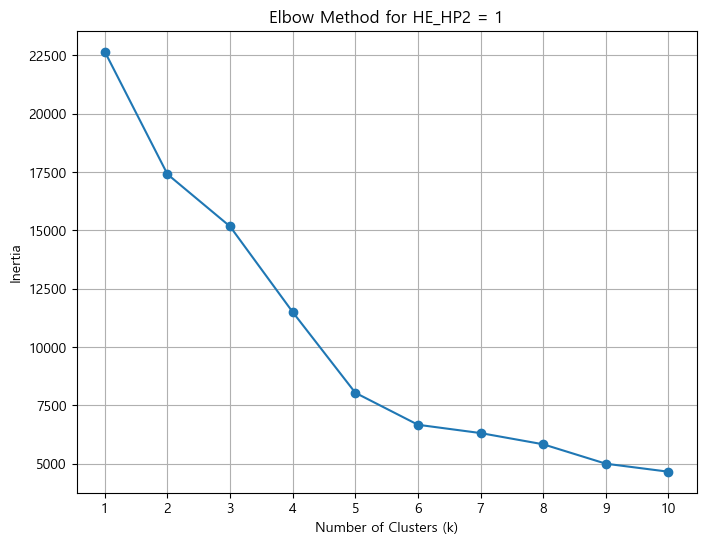

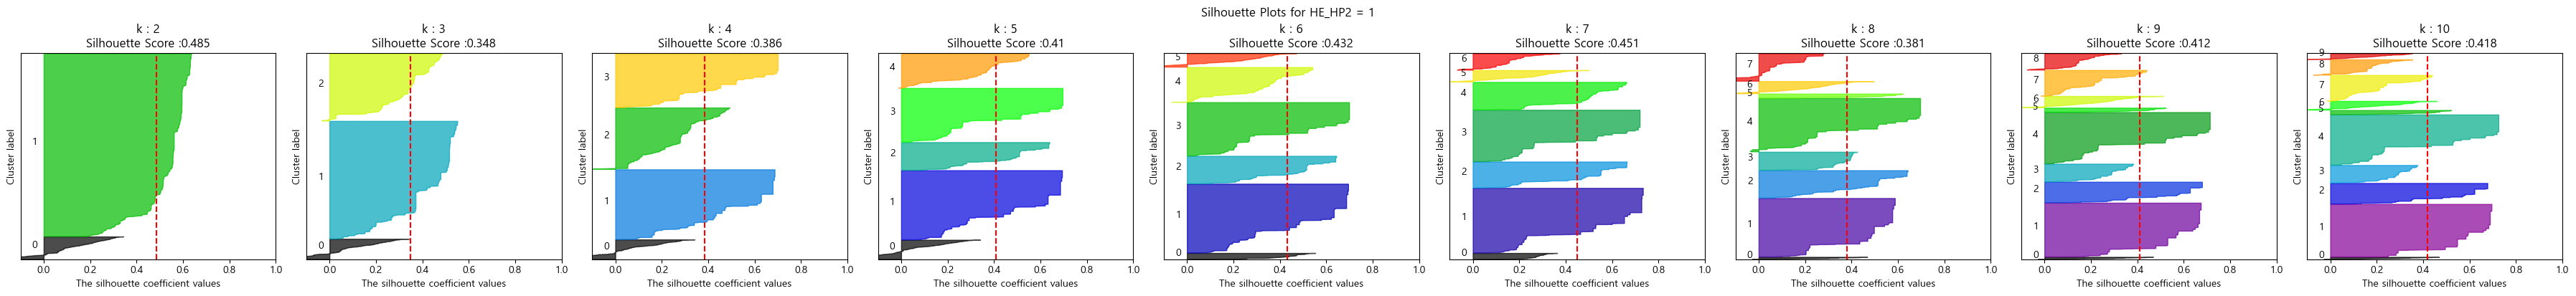


--- Processing HE_HP2 = 2 ---


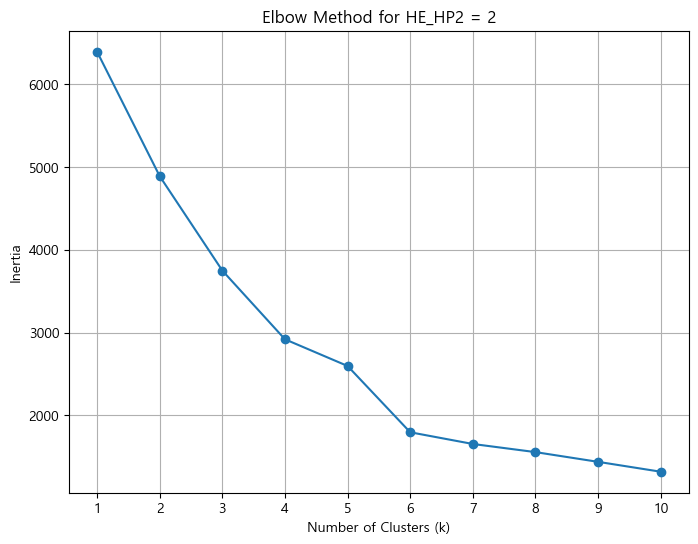

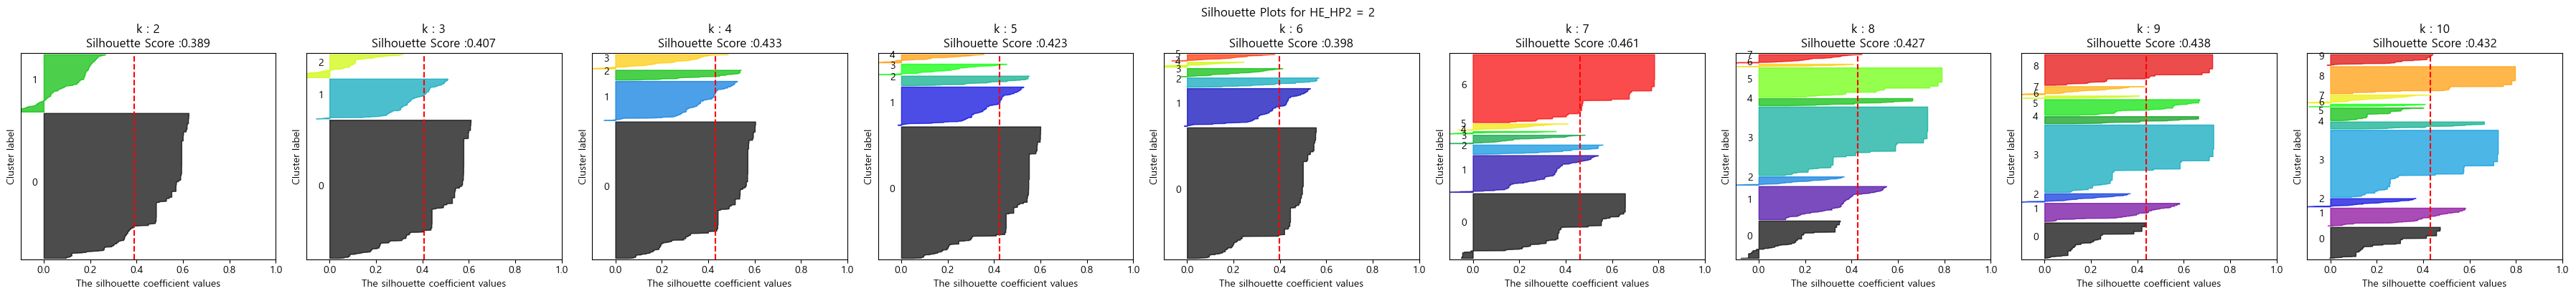


--- Processing HE_HP2 = 3 ---


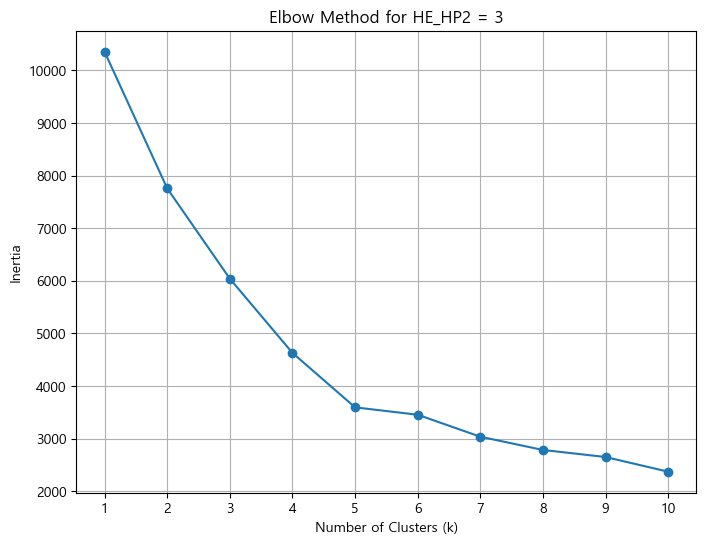

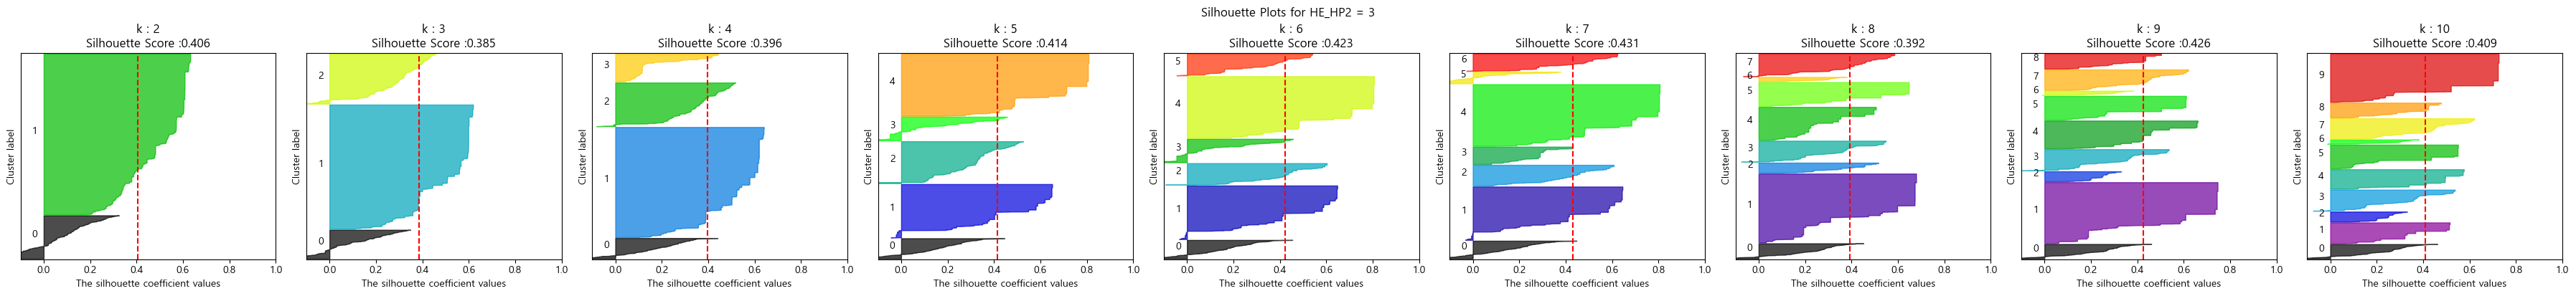


--- Processing HE_HP2 = 4 ---


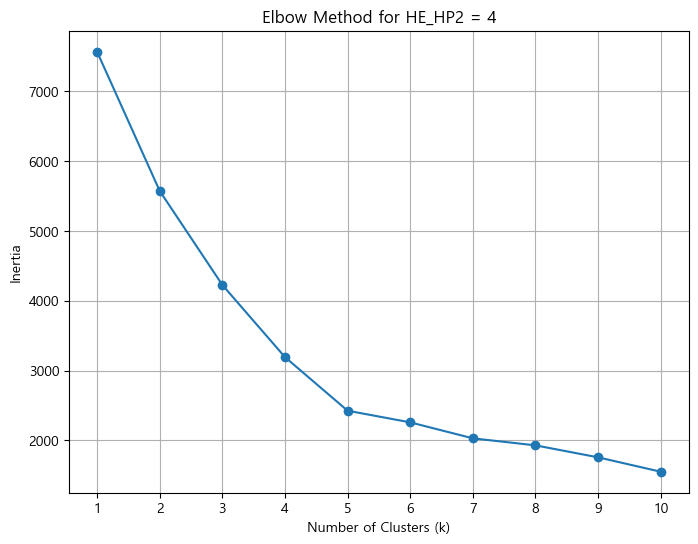

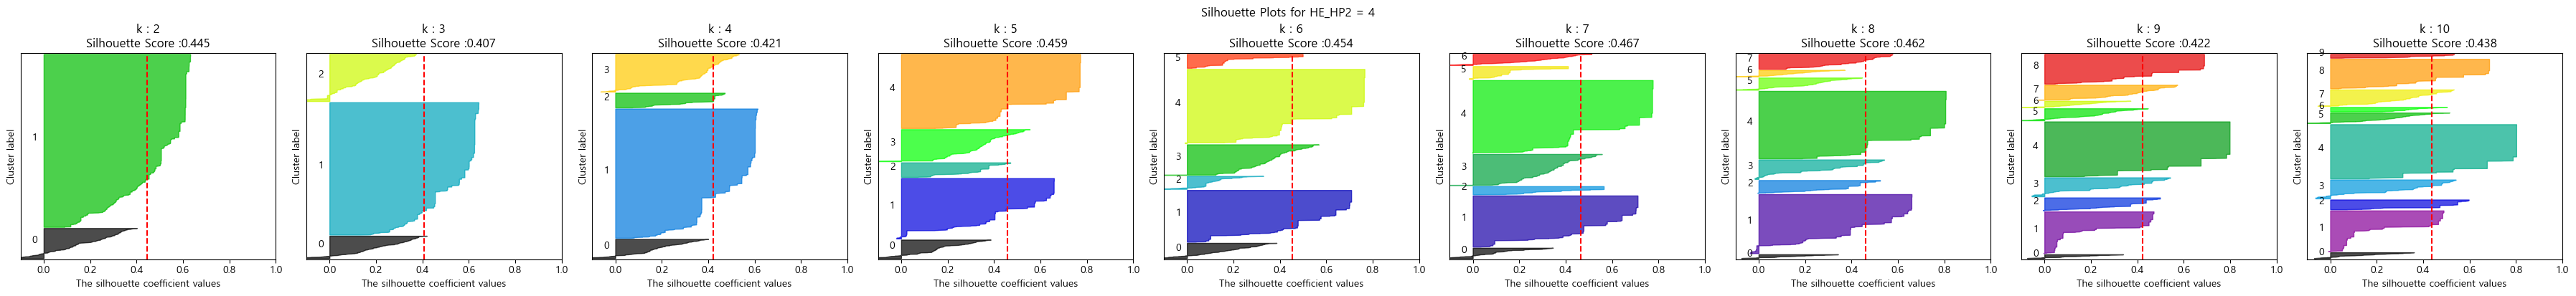


--- Processing complete ---


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans # KMeans 필요
from sklearn.preprocessing import StandardScaler # StandardScaler 필요
from sklearn.metrics import silhouette_samples, silhouette_score # silhouette_samples, silhouette_score 임포트 추가

# Assume df_clustering and knn_columns are defined and initialized before this snippet
# 예시 정의 (실제 코드에서는 이전에 정의된 변수를 사용해야 합니다)
# df_clustering = pd.read_csv("your_clustering_data.csv") # 실제 파일 경로
# knn_columns = ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'] # 실제 knn_columns 목록


# 피처 표준화
scaler = StandardScaler()

# 클러스터 수 범위 설정 (엘보우 및 실루엣 시각화에 사용할 최대 k)
k_range_max = 10 # 최대 10개 클러스터까지 탐색

# 결과를 저장할 데이터프레임 준비
# 'Cluster' 칼럼이 이미 있다면 이 줄은 필요 없을 수 있습니다.
# df_clustering['Cluster'] = np.nan

# 군집 분석에 사용할 피처 목록 정의
# knn_columns와 추가 피처들을 결합합니다.
try:
    selected_cols =['BE3_31','BD1_11', 'L_BR_FQ', 'tobacco']
    # selected_cols에 포함된 모든 칼럼이 df_clustering에 있는지 확인하는 것이 안전합니다.
    missing_selected_cols = [col for col in selected_cols if col not in df_clustering.columns]
    if missing_selected_cols:
        print(f"Warning: Selected columns not found in df_clustering: {missing_selected_cols}")
        # 데이터에 없는 칼럼은 selected_cols에서 제외하고 진행할 수 있습니다.
        selected_cols = [col for col in selected_cols if col in df_clustering.columns]
        print(f"Using selected_cols found in data: {selected_cols}")

except NameError:
    print("Error: knn_columns is not defined. Please define knn_columns before running this code.")
    # knn_columns가 정의되지 않았을 경우의 예시 selected_cols (실제 사용하실 피처 목록으로 대체하세요)
    selected_cols = ["HE_sbp1", "HE_dbp1", "HE_wc", "HE_glu", "HE_HbA1c", "BD1_11", "tobacco", "BE5_1", "LS_VEG1"]
    print(f"Using example selected_cols: {selected_cols}")

# selected_cols가 비어있으면 분석 진행 불가
if not selected_cols:
    print("Error: selected_cols is empty. Cannot proceed with clustering.")
    # 스크립트 실행 중단 또는 적절한 오류 처리
    # exit()


# HE_HP 별로 반복
# df_clustering['HE_HP'] 칼럼이 존재하고, 그 값이 [1, 2, 3, 4] 중에 있다고 가정합니다.
# 실제 df_clustering['HE_HP']의 고유값 리스트를 사용하는 것이 더 안전합니다.
if 'HE_HP2' not in df_clustering.columns:
    print("Error: 'HE_HP2' column not found in df_clustering. Cannot perform clustering by HE_HP.")
    # 스크립트 실행 중단 또는 적절한 오류 처리
    # exit()

# HE_HP의 실제 고유값 가져오기 및 정렬
he_hp_values = sorted(df_clustering['HE_HP2'].dropna().unique().tolist())
# 만약 특정 HE_HP 값만 분석하고 싶다면 아래 리스트를 사용
# he_hp_values_to_process = [1, 2, 3, 4] # 분석할 HE_HP 값 목록

for hp_value in he_hp_values: # 실제 HE_HP 고유값 사용
    print(f"\n--- Processing HE_HP2 = {hp_value} ---")

    # HE_HP 값에 해당하는 데이터 추출
    # selected_cols에 해당하는 칼럼만 선택합니다.
    hp_df = df_clustering[df_clustering['HE_HP2'] == hp_value][selected_cols].copy()

    if not hp_df.empty and len(hp_df) > 1: # 데이터 포인트가 1개보다 많아야 클러스터링 의미 있음
        # 데이터 표준화
        # 각 그룹별로 별도의 scaler를 fit/transform 합니다.
        scaled_df = scaler.fit_transform(hp_df)

        # 클러스터 개수가 데이터 포인트 개수보다 많을 수는 없으므로 범위를 조정
        # 또한, 실루엣 계수 등 다른 검증 지표를 사용하려면 k>1 이어야 합니다.
        max_k_current_group = min(len(scaled_df), k_range_max) # 현재 그룹 데이터 개수와 최대 범위 중 작은 값

        if max_k_current_group < 2:
             print(f" Not enough data points ({len(scaled_df)}) for HE_HP2 = {hp_value} to perform clustering for k > 1.")
             continue # 다음 HE_HP 값으로 넘어감


        # --- 엘보우 방법: 각 k에 대해 관성(Inertia) 계산 ---
        # 관성을 계산할 k 범위 (최소 1부터 시작)
        k_range_inertia = range(1, max_k_current_group + 1)
        inertias = []
        for k in k_range_inertia:
            # n_init='auto' 또는 숫자로 지정 (최신 sklearn 버전 권장)
            # k=1일때는 n_init=1로 설정 가능
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            kmeans.fit(scaled_df)
            inertias.append(kmeans.inertia_)

        # 엘보우 플롯 시각화
        plt.figure(figsize=(8, 6))
        plt.plot(k_range_inertia, inertias, marker='o')
        plt.title(f'Elbow Method for HE_HP2 = {hp_value}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.xticks(k_range_inertia) # x축 틱을 k 범위로 설정
        plt.grid(True)
        plt.show()

        # --- 실루엣 계수 시각화 ---
        # 실루엣 계수를 계산할 k 범위 (최소 2부터 시작)
        k_range_silhouette = range(2, max_k_current_group + 1)

        if len(k_range_silhouette) > 0: # k_range_silhouette가 비어있지 않을 때만 시각화
            n_cols = len(k_range_silhouette)

            # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
            # squeeze=False를 사용하여 n_cols=1일 때도 axs가 항상 2D 배열이 되도록 합니다.
            fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols, squeeze=False)
            axs = axs.reshape(-1) # 1D 배열로 평탄화

            # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
            for ind, n_cluster in enumerate(k_range_silhouette):
                ax = axs[ind] # 각 서브플롯 선택

                try:
                    # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
                    # n_init='auto' 또는 숫자로 지정 필요
                    clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0, n_init='auto')
                    cluster_labels = clusterer.fit_predict(scaled_df)

                    # 실루엣 점수 계산
                    # 데이터 포인트가 1개보다 많고 클러스터 개수가 1개보다 많을 때만 계산 가능
                    if len(np.unique(cluster_labels)) > 1 and scaled_df.shape[0] > 1:
                         sil_avg = silhouette_score(scaled_df, cluster_labels)
                         sil_values = silhouette_samples(scaled_df, cluster_labels)
                    else:
                         sil_avg = 0 # 계산 불가 시 0 또는 NaN으로 처리
                         sil_values = np.zeros(scaled_df.shape[0]) # 모든 샘플 점수 0으로 처리
                         print(f" Silhouette score not computable for k={n_cluster} (less than 2 clusters or data points).")


                    y_lower = 10 # 첫 번째 클러스터 플롯의 시작 위치

                    # 플롯 제목 설정 (k값 및 평균 실루엣 점수 포함)
                    ax.set_title('k : ' + str(n_cluster)+'\n' \
                                 'Silhouette Score :' + str(round(sil_avg,3)) )
                    ax.set_xlabel("The silhouette coefficient values")
                    ax.set_ylabel("Cluster label")
                    ax.set_xlim([-0.1, 1]) # x축 범위 설정
                    # y축 범위 설정: 데이터 포인트 총 수 + (클러스터 개수 + 1) * 클러스터 간 간격
                    ax.set_ylim([0, len(scaled_df) + (n_cluster + 1) * 10])
                    ax.set_yticks([])  # yaxis labels / ticks 제거
                    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1]) # x축 틱 설정

                    # 각 클러스터별 실루엣 플롯 그리기
                    # 클러스터 라벨 순서대로 정렬하여 그립니다.
                    unique_labels = np.unique(cluster_labels)
                    unique_labels.sort() # 라벨을 오름차순으로 정렬하여 일관성 확보

                    for i in unique_labels: # 정렬된 고유 라벨 순회
                        # i번째 클러스터에 해당하는 실루엣 점수 가져오기
                        ith_cluster_sil_values = sil_values[cluster_labels == i]
                        ith_cluster_sil_values.sort() # 점수 정렬

                        size_cluster_i = ith_cluster_sil_values.shape[0] # 클러스터 i의 샘플 수
                        y_upper = y_lower + size_cluster_i # 현재 클러스터 플롯의 끝 위치

                        # 클러스터 색상 설정
                        color = cm.nipy_spectral(float(i) / len(unique_labels)) # 고유 라벨 개수로 색상 스케일링
                        # fill_betweenx를 사용하여 실루엣 점수 영역 채우기
                        ax.fill_betweenx(np.arange(y_lower, y_upper),
                                         0, ith_cluster_sil_values,
                                         facecolor=color, edgecolor=color, alpha=0.7)

                        # 클러스터 번호 텍스트 추가
                        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                        # 다음 클러스터 플롯을 위한 y_lower 위치 업데이트
                        y_lower = y_upper + 10 # 클러스터 간 간격 추가

                    # 평균 실루엣 점수 라인 추가
                    ax.axvline(x=sil_avg, color="red", linestyle="--")

                except Exception as e:
                    print(f"  Error visualizing silhouette for k={n_cluster}: {e}")
                    ax.set_title(f'k={n_cluster} (Error)')
                    ax.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
                    ax.set_xticks([])
                    ax.set_yticks([])

            # 전체 플롯 레이아웃 조정 및 제목 추가
            plt.tight_layout()
            plt.suptitle(f'Silhouette Plots for HE_HP2 = {hp_value}', y=1.02) # 전체 제목에 HE_HP 값 포함
            plt.show()

        else:
            print(f" Not enough data points ({len(scaled_df)}) for HE_HP2 = {hp_value} to perform clustering for k > 1 for silhouette visualization.")



    else:
        print(f"No data or insufficient data points ({len(hp_df)}) for HE_HP2 = {hp_value} to perform clustering.")
        # 데이터가 없거나 부족하면 해당 HE_HP 값에 대한 클러스터 라벨을 NaN으로 유지
        # df_clustering.loc[hp_df.index, 'Cluster'] = np.nan # 이미 초기화 시 np.nan 이므로 필요 없을 수 있습니다.


print("\n--- Processing complete ---")

# 루프가 완료된 후, df_clustering 데이터프레임에는 각 HE_HP 그룹에 대해
# 결정된 optimal_k로 군집화된 'Cluster' 라벨이 추가되어 있습니다.
# 이제 이 df_clustering를 사용하여 군집별 특징 분석, 시각화 등을 수행할 수 있습니다.


음주 흡연 걷기 외식 


--- Processing HE_HP2 = 1 ---


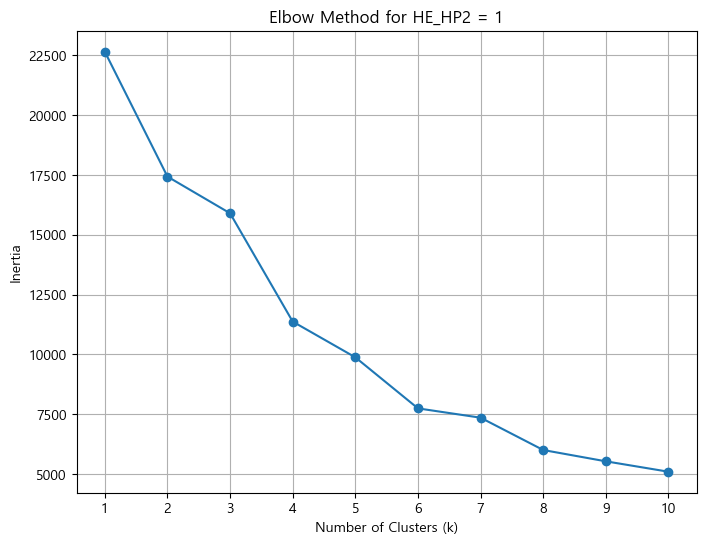

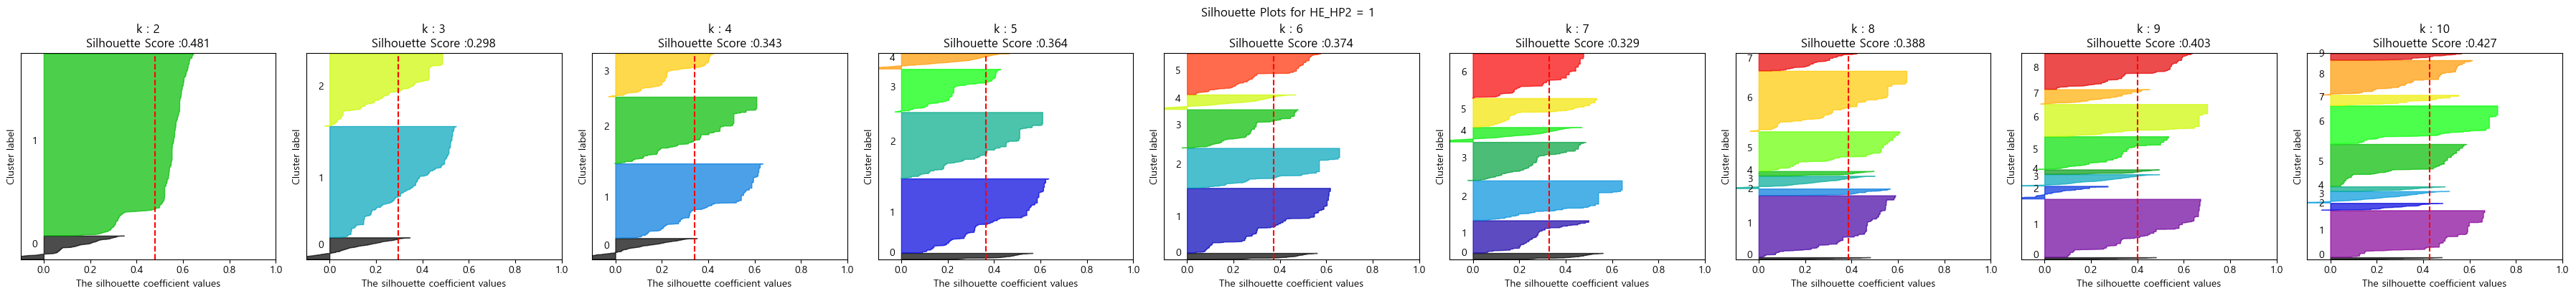


--- Processing HE_HP2 = 2 ---


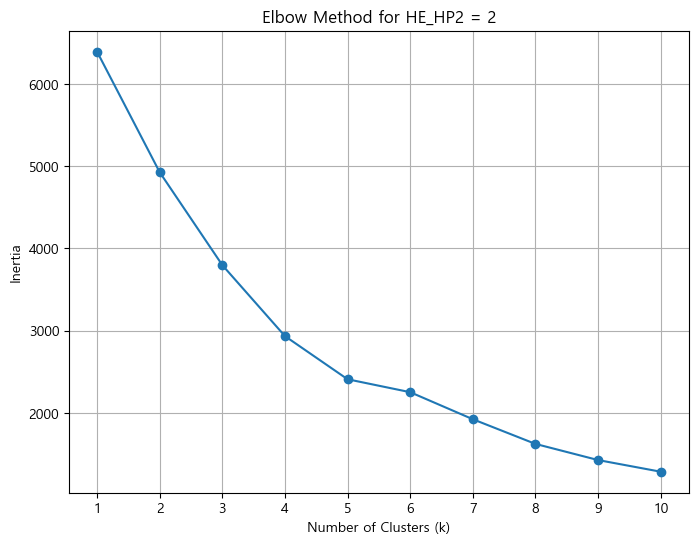

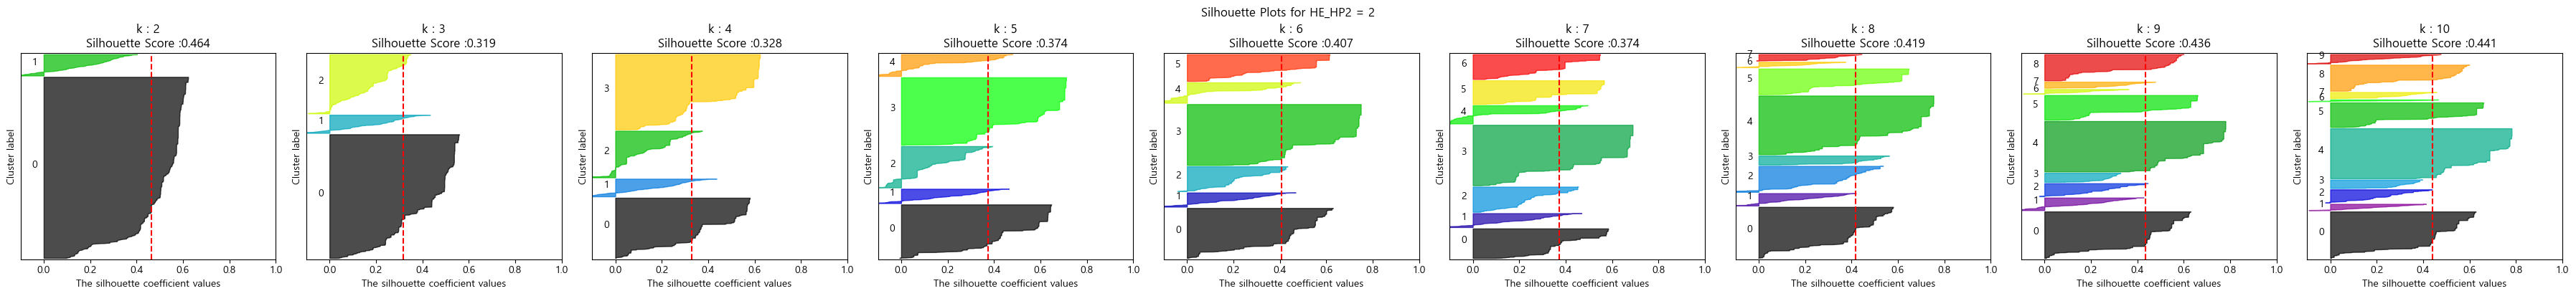


--- Processing HE_HP2 = 3 ---


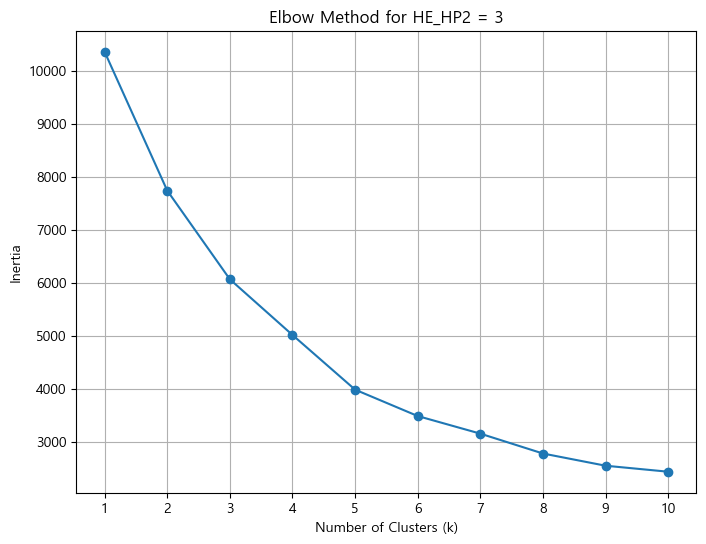

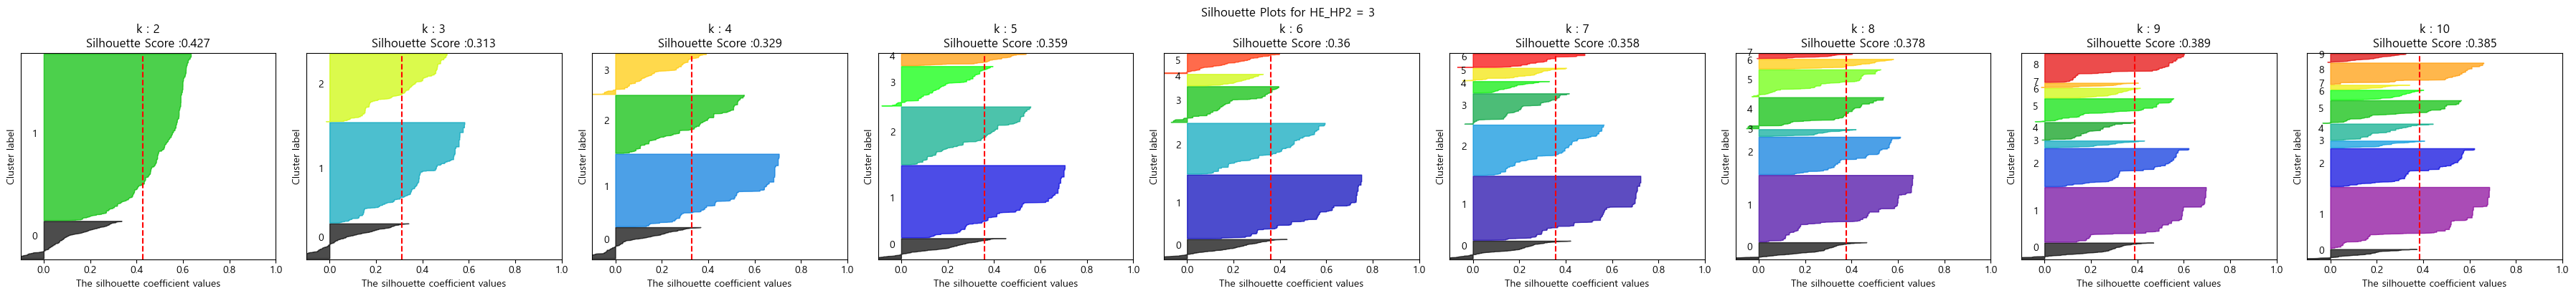


--- Processing HE_HP2 = 4 ---


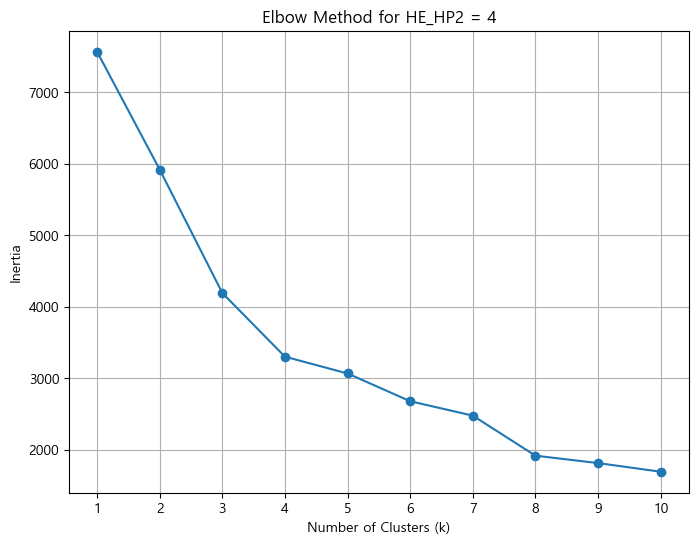

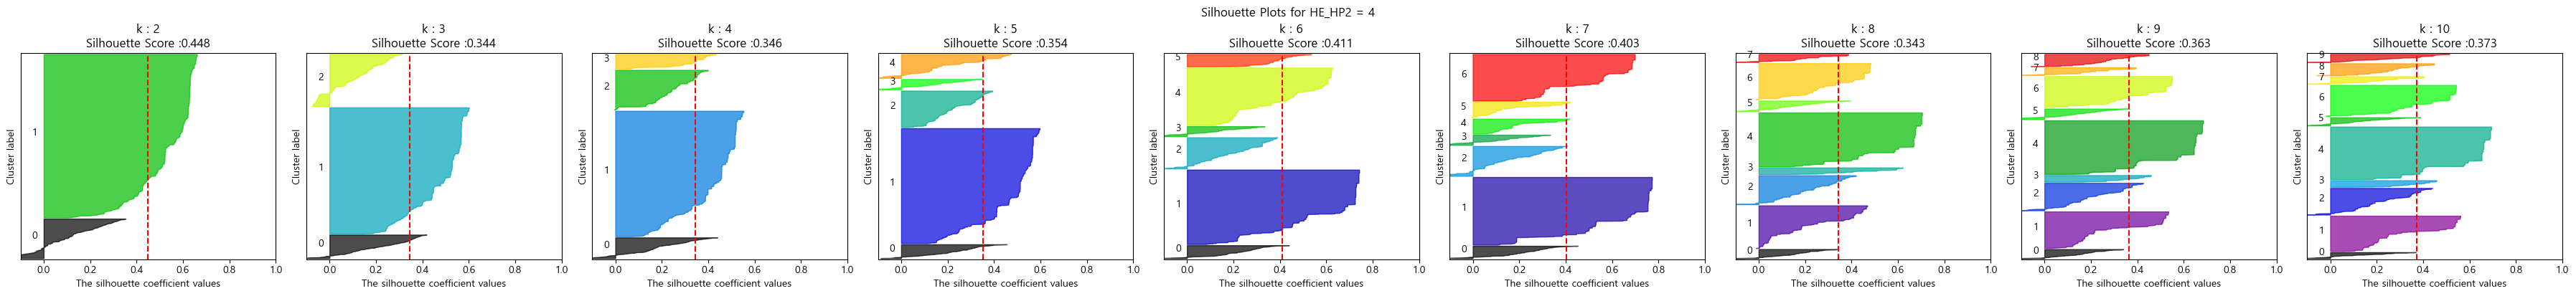


--- Processing complete ---


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans # KMeans 필요
from sklearn.preprocessing import StandardScaler # StandardScaler 필요
from sklearn.metrics import silhouette_samples, silhouette_score # silhouette_samples, silhouette_score 임포트 추가

# Assume df_clustering and knn_columns are defined and initialized before this snippet
# 예시 정의 (실제 코드에서는 이전에 정의된 변수를 사용해야 합니다)
# df_clustering = pd.read_csv("your_clustering_data.csv") # 실제 파일 경로
# knn_columns = ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'] # 실제 knn_columns 목록


# 피처 표준화
scaler = StandardScaler()

# 클러스터 수 범위 설정 (엘보우 및 실루엣 시각화에 사용할 최대 k)
k_range_max = 10 # 최대 10개 클러스터까지 탐색

# 결과를 저장할 데이터프레임 준비
# 'Cluster' 칼럼이 이미 있다면 이 줄은 필요 없을 수 있습니다.
# df_clustering['Cluster'] = np.nan

# 군집 분석에 사용할 피처 목록 정의
# knn_columns와 추가 피처들을 결합합니다.
try:
    selected_cols =['BE3_31','BD1_11', 'tobacco','L_OUT_FQ']
    # selected_cols에 포함된 모든 칼럼이 df_clustering에 있는지 확인하는 것이 안전합니다.
    missing_selected_cols = [col for col in selected_cols if col not in df_clustering.columns]
    if missing_selected_cols:
        print(f"Warning: Selected columns not found in df_clustering: {missing_selected_cols}")
        # 데이터에 없는 칼럼은 selected_cols에서 제외하고 진행할 수 있습니다.
        selected_cols = [col for col in selected_cols if col in df_clustering.columns]
        print(f"Using selected_cols found in data: {selected_cols}")

except NameError:
    print("Error: knn_columns is not defined. Please define knn_columns before running this code.")
    # knn_columns가 정의되지 않았을 경우의 예시 selected_cols (실제 사용하실 피처 목록으로 대체하세요)
    selected_cols = ["HE_sbp1", "HE_dbp1", "HE_wc", "HE_glu", "HE_HbA1c", "BD1_11", "tobacco", "BE5_1", "LS_VEG1"]
    print(f"Using example selected_cols: {selected_cols}")

# selected_cols가 비어있으면 분석 진행 불가
if not selected_cols:
    print("Error: selected_cols is empty. Cannot proceed with clustering.")
    # 스크립트 실행 중단 또는 적절한 오류 처리
    # exit()


# HE_HP 별로 반복
# df_clustering['HE_HP'] 칼럼이 존재하고, 그 값이 [1, 2, 3, 4] 중에 있다고 가정합니다.
# 실제 df_clustering['HE_HP']의 고유값 리스트를 사용하는 것이 더 안전합니다.
if 'HE_HP2' not in df_clustering.columns:
    print("Error: 'HE_HP2' column not found in df_clustering. Cannot perform clustering by HE_HP.")
    # 스크립트 실행 중단 또는 적절한 오류 처리
    # exit()

# HE_HP의 실제 고유값 가져오기 및 정렬
he_hp_values = sorted(df_clustering['HE_HP2'].dropna().unique().tolist())
# 만약 특정 HE_HP 값만 분석하고 싶다면 아래 리스트를 사용
# he_hp_values_to_process = [1, 2, 3, 4] # 분석할 HE_HP 값 목록

for hp_value in he_hp_values: # 실제 HE_HP 고유값 사용
    print(f"\n--- Processing HE_HP2 = {hp_value} ---")

    # HE_HP 값에 해당하는 데이터 추출
    # selected_cols에 해당하는 칼럼만 선택합니다.
    hp_df = df_clustering[df_clustering['HE_HP2'] == hp_value][selected_cols].copy()

    if not hp_df.empty and len(hp_df) > 1: # 데이터 포인트가 1개보다 많아야 클러스터링 의미 있음
        # 데이터 표준화
        # 각 그룹별로 별도의 scaler를 fit/transform 합니다.
        scaled_df = scaler.fit_transform(hp_df)

        # 클러스터 개수가 데이터 포인트 개수보다 많을 수는 없으므로 범위를 조정
        # 또한, 실루엣 계수 등 다른 검증 지표를 사용하려면 k>1 이어야 합니다.
        max_k_current_group = min(len(scaled_df), k_range_max) # 현재 그룹 데이터 개수와 최대 범위 중 작은 값

        if max_k_current_group < 2:
             print(f" Not enough data points ({len(scaled_df)}) for HE_HP2 = {hp_value} to perform clustering for k > 1.")
             continue # 다음 HE_HP 값으로 넘어감


        # --- 엘보우 방법: 각 k에 대해 관성(Inertia) 계산 ---
        # 관성을 계산할 k 범위 (최소 1부터 시작)
        k_range_inertia = range(1, max_k_current_group + 1)
        inertias = []
        for k in k_range_inertia:
            # n_init='auto' 또는 숫자로 지정 (최신 sklearn 버전 권장)
            # k=1일때는 n_init=1로 설정 가능
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            kmeans.fit(scaled_df)
            inertias.append(kmeans.inertia_)

        # 엘보우 플롯 시각화
        plt.figure(figsize=(8, 6))
        plt.plot(k_range_inertia, inertias, marker='o')
        plt.title(f'Elbow Method for HE_HP2 = {hp_value}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.xticks(k_range_inertia) # x축 틱을 k 범위로 설정
        plt.grid(True)
        plt.show()

        # --- 실루엣 계수 시각화 ---
        # 실루엣 계수를 계산할 k 범위 (최소 2부터 시작)
        k_range_silhouette = range(2, max_k_current_group + 1)

        if len(k_range_silhouette) > 0: # k_range_silhouette가 비어있지 않을 때만 시각화
            n_cols = len(k_range_silhouette)

            # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
            # squeeze=False를 사용하여 n_cols=1일 때도 axs가 항상 2D 배열이 되도록 합니다.
            fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols, squeeze=False)
            axs = axs.reshape(-1) # 1D 배열로 평탄화

            # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
            for ind, n_cluster in enumerate(k_range_silhouette):
                ax = axs[ind] # 각 서브플롯 선택

                try:
                    # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
                    # n_init='auto' 또는 숫자로 지정 필요
                    clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0, n_init='auto')
                    cluster_labels = clusterer.fit_predict(scaled_df)

                    # 실루엣 점수 계산
                    # 데이터 포인트가 1개보다 많고 클러스터 개수가 1개보다 많을 때만 계산 가능
                    if len(np.unique(cluster_labels)) > 1 and scaled_df.shape[0] > 1:
                         sil_avg = silhouette_score(scaled_df, cluster_labels)
                         sil_values = silhouette_samples(scaled_df, cluster_labels)
                    else:
                         sil_avg = 0 # 계산 불가 시 0 또는 NaN으로 처리
                         sil_values = np.zeros(scaled_df.shape[0]) # 모든 샘플 점수 0으로 처리
                         print(f" Silhouette score not computable for k={n_cluster} (less than 2 clusters or data points).")


                    y_lower = 10 # 첫 번째 클러스터 플롯의 시작 위치

                    # 플롯 제목 설정 (k값 및 평균 실루엣 점수 포함)
                    ax.set_title('k : ' + str(n_cluster)+'\n' \
                                 'Silhouette Score :' + str(round(sil_avg,3)) )
                    ax.set_xlabel("The silhouette coefficient values")
                    ax.set_ylabel("Cluster label")
                    ax.set_xlim([-0.1, 1]) # x축 범위 설정
                    # y축 범위 설정: 데이터 포인트 총 수 + (클러스터 개수 + 1) * 클러스터 간 간격
                    ax.set_ylim([0, len(scaled_df) + (n_cluster + 1) * 10])
                    ax.set_yticks([])  # yaxis labels / ticks 제거
                    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1]) # x축 틱 설정

                    # 각 클러스터별 실루엣 플롯 그리기
                    # 클러스터 라벨 순서대로 정렬하여 그립니다.
                    unique_labels = np.unique(cluster_labels)
                    unique_labels.sort() # 라벨을 오름차순으로 정렬하여 일관성 확보

                    for i in unique_labels: # 정렬된 고유 라벨 순회
                        # i번째 클러스터에 해당하는 실루엣 점수 가져오기
                        ith_cluster_sil_values = sil_values[cluster_labels == i]
                        ith_cluster_sil_values.sort() # 점수 정렬

                        size_cluster_i = ith_cluster_sil_values.shape[0] # 클러스터 i의 샘플 수
                        y_upper = y_lower + size_cluster_i # 현재 클러스터 플롯의 끝 위치

                        # 클러스터 색상 설정
                        color = cm.nipy_spectral(float(i) / len(unique_labels)) # 고유 라벨 개수로 색상 스케일링
                        # fill_betweenx를 사용하여 실루엣 점수 영역 채우기
                        ax.fill_betweenx(np.arange(y_lower, y_upper),
                                         0, ith_cluster_sil_values,
                                         facecolor=color, edgecolor=color, alpha=0.7)

                        # 클러스터 번호 텍스트 추가
                        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                        # 다음 클러스터 플롯을 위한 y_lower 위치 업데이트
                        y_lower = y_upper + 10 # 클러스터 간 간격 추가

                    # 평균 실루엣 점수 라인 추가
                    ax.axvline(x=sil_avg, color="red", linestyle="--")

                except Exception as e:
                    print(f"  Error visualizing silhouette for k={n_cluster}: {e}")
                    ax.set_title(f'k={n_cluster} (Error)')
                    ax.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
                    ax.set_xticks([])
                    ax.set_yticks([])

            # 전체 플롯 레이아웃 조정 및 제목 추가
            plt.tight_layout()
            plt.suptitle(f'Silhouette Plots for HE_HP2 = {hp_value}', y=1.02) # 전체 제목에 HE_HP 값 포함
            plt.show()

        else:
            print(f" Not enough data points ({len(scaled_df)}) for HE_HP2 = {hp_value} to perform clustering for k > 1 for silhouette visualization.")



    else:
        print(f"No data or insufficient data points ({len(hp_df)}) for HE_HP2 = {hp_value} to perform clustering.")
        # 데이터가 없거나 부족하면 해당 HE_HP 값에 대한 클러스터 라벨을 NaN으로 유지
        # df_clustering.loc[hp_df.index, 'Cluster'] = np.nan # 이미 초기화 시 np.nan 이므로 필요 없을 수 있습니다.


print("\n--- Processing complete ---")

# 루프가 완료된 후, df_clustering 데이터프레임에는 각 HE_HP 그룹에 대해
# 결정된 optimal_k로 군집화된 'Cluster' 라벨이 추가되어 있습니다.
# 이제 이 df_clustering를 사용하여 군집별 특징 분석, 시각화 등을 수행할 수 있습니다.


3개 방법 비교 


--- Processing HE_HP2 = 1 with k = 6 ---
Comparing algorithms for k = 6:
 - KMeans: Silhouette Score = 0.1873
 - Agglomerative: Silhouette Score = 0.1711
 - MiniBatchKMeans: Silhouette Score = 0.2050

Best algorithm for HE_HP2 = 1 (k=6): MiniBatchKMeans (Silhouette Score: 0.2050)
Cluster Characteristics (Mean values for HE_HP2 = 1, k=6) - Modified:
             1주일 간 음주 빈도  하루 평균 흡연량  1주일 간 걷기 일수  1주 동안 외식 식사 빈도
New_Cluster                                                     
0               0.248367   0.314103     0.872596      202.876603
1               0.358108   0.361932     6.060227      121.079545
2               1.236695  20.380665     3.700906      201.927492
3               0.611325   1.400000     3.677778      730.000000
4               3.409639   2.821285     4.339357      203.873494
5               0.293859   0.668287     3.686513      215.874241
------------------------------------------------------------


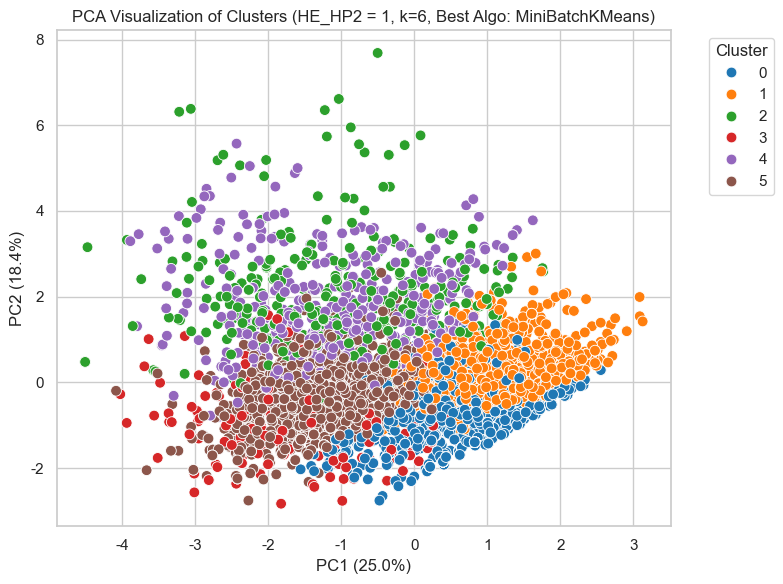


--- Processing HE_HP2 = 2 with k = 6 ---
Comparing algorithms for k = 6:
 - KMeans: Silhouette Score = 0.2021
 - Agglomerative: Silhouette Score = 0.1699
 - MiniBatchKMeans: Silhouette Score = 0.1609

Best algorithm for HE_HP2 = 2 (k=6): KMeans (Silhouette Score: 0.2021)
Cluster Characteristics (Mean values for HE_HP2 = 2, k=6) - Modified:
             1주일 간 음주 빈도  하루 평균 흡연량  1주일 간 걷기 일수  1주 동안 외식 식사 빈도
New_Cluster                                                     
0               0.311966   0.423729     6.386064       97.723164
1               0.508876   0.945055     2.489011      411.719780
2               1.058252  20.203883     3.485437      228.524272
3               5.500000   4.129870     4.129870      162.701299
4               0.624504   0.773196     4.604811      153.192440
5               0.361018   0.500000     1.398551      106.152174
------------------------------------------------------------


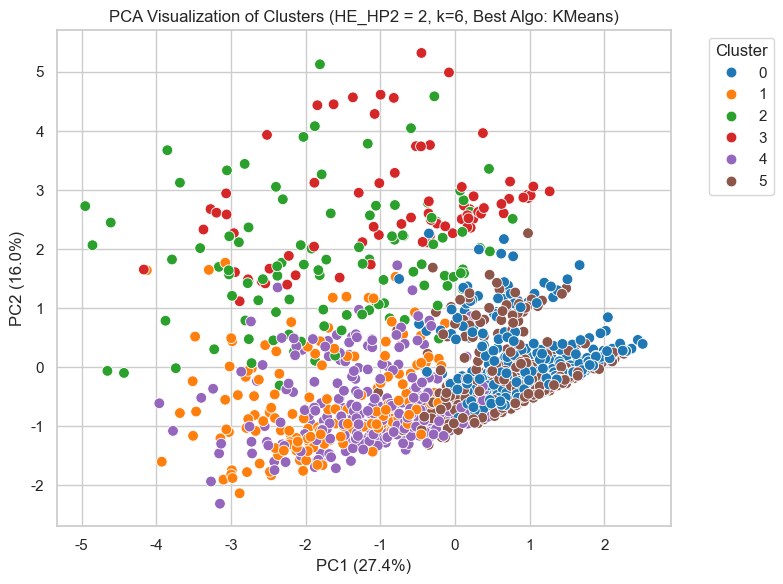


--- Processing HE_HP2 = 3 with k = 6 ---
Comparing algorithms for k = 6:
 - KMeans: Silhouette Score = 0.1943
 - Agglomerative: Silhouette Score = 0.1716
 - MiniBatchKMeans: Silhouette Score = 0.1385

Best algorithm for HE_HP2 = 3 (k=6): KMeans (Silhouette Score: 0.1943)
Cluster Characteristics (Mean values for HE_HP2 = 3, k=6) - Modified:
             1주일 간 음주 빈도  하루 평균 흡연량  1주일 간 걷기 일수  1주 동안 외식 식사 빈도
New_Cluster                                                     
0               5.500000   4.316456     4.145570      197.101266
1               0.783991   0.800439     6.260965      171.804825
2               0.382351   0.302538     4.481218       51.829442
3               1.841639  19.634783     3.373913      235.104348
4               0.813675   0.847222     4.122222      396.936111
5               0.624327   1.350000     1.370000      189.367500
------------------------------------------------------------


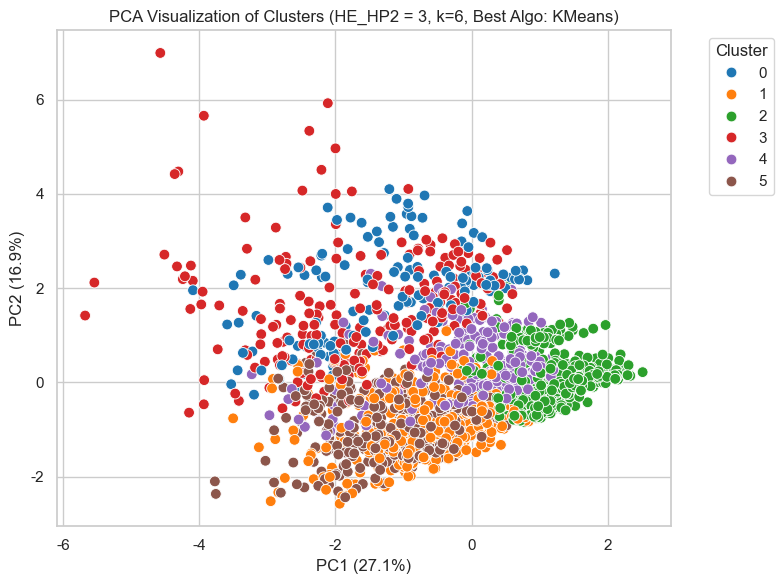


--- Processing HE_HP2 = 4 with k = 6 ---
Comparing algorithms for k = 6:
 - KMeans: Silhouette Score = 0.1736
 - Agglomerative: Silhouette Score = 0.1620
 - MiniBatchKMeans: Silhouette Score = 0.1791

Best algorithm for HE_HP2 = 4 (k=6): MiniBatchKMeans (Silhouette Score: 0.1791)
Cluster Characteristics (Mean values for HE_HP2 = 4, k=6) - Modified:
             1주일 간 음주 빈도  하루 평균 흡연량  1주일 간 걷기 일수  1주 동안 외식 식사 빈도
New_Cluster                                                     
0               4.318213  12.704036     3.659193      172.156951
1               0.388362   0.399351     5.519481       84.639610
2               0.455493   0.546169     6.361493      104.603143
3               1.320051   2.434903     3.759003      193.468144
4               2.080561   6.540541     4.202703      670.810811
5               0.422892   0.419664     1.047962       83.333333
------------------------------------------------------------


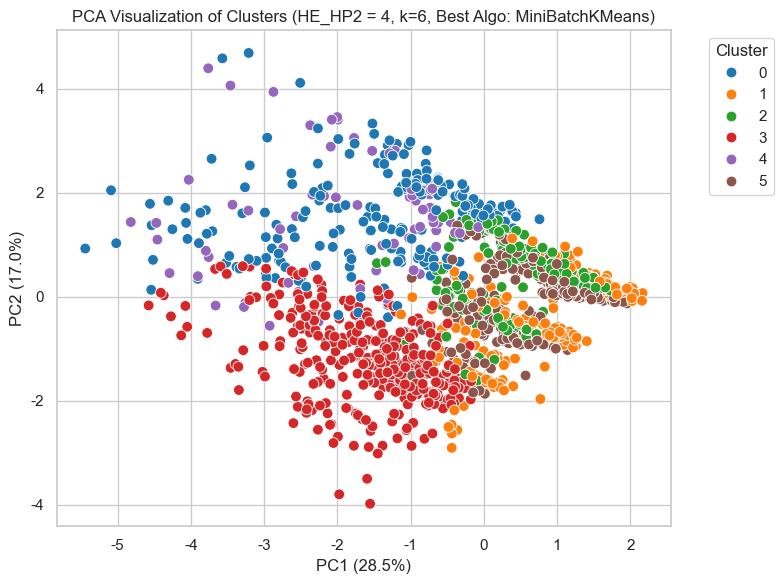


--- Processing complete ---


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans # AgglomerativeClustering, DBSCAN, MiniBatchKMeans 임포트 추가
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# RandomForestClassifier는 이 특정 스니펫에서 직접 사용되지 않으므로 주석 처리하거나 필요에 따라 유지
# from sklearn.ensemble import RandomForestClassifier

# 통계 분석을 위한 라이브러리 임포트 (이 스니펫에서 직접 사용되지는 않음)
# from scipy import stats
# import statsmodels.api as sm
# from statsmodels.stats.contingency_tables import Table

# 시각화 설정
sns.set(style="whitegrid")

# 전처리 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def preprocess_data(df, original_numeric_cols, original_categorical_cols): ...

# select_features 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def select_features(df, columns, corr_threshold=0.8): ...

# compute_feature_importance 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def compute_feature_importance(df_processed, selected_cols, cluster_labels): ...

# visualize_silhouette 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def visualize_silhouette(cluster_lists, X_features): ...

# run_clustering_iteration 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm): ...


# 매핑 딕셔너리 정의 (피처 이름 -> 한글 설명)
# 이 딕셔너리는 selected_cols에 있는 피처 이름에 대한 설명을 포함해야 합니다.
feature_korean_names = {
    'HE_sbp1': '수축기 혈압 (최고 혈압)',
    'HE_dbp1': '이완기 혈압 (최저 혈압)',
    'HE_wc': '허리둘레',
    'HE_glu': '혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤 (좋은 콜레스테롤)',
    'HE_LDL_drct': 'LDL 콜레스테롤 (나쁜 콜레스테롤)',
    'HE_crea': '크레아티닌 (신장 기능 지표)',
    'HE_ast': 'AST (간 기능 검사, GOT)',
    'HE_alt': 'ALT (간 기능 검사, GPT)',
    'HE_wt': '체중',
    'HE_ht': '키',
    'HE_BMI': '체질량 지수 (BMI)',
    'BD1_11': '1년 간 음주 빈도',
    'tobacco': '하루 평균 흡연량', # 이 피처가 selected_cols에 있는지 확인 필요
    'BE3_31' : '1주일 간 걷기 일수',
    'L_OUT_FQ': '1주 동안 외식 식사 빈도',
    # selected_cols에 포함된 다른 피처들도 여기에 추가해야 합니다.
    'age': '나이', 'sex': '성별', 'HE_HbA1c': '당화혈색소', # 예시 추가
    # ... selected_cols에 있는 모든 피처에 대한 매핑 추가 ...
}

# 시각화 설정
sns.set(style="whitegrid")

# Assume df_clustering, selected_cols, scaler are defined and initialized before this snippet
# 예시 정의 (실제 코드에서는 이전에 정의된 변수를 사용해야 합니다)
# df_clustering = pd.read_csv("your_clustering_data.csv") # 실제 파일 경로
# selected_cols = ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI', 'BD1_11', 'tobacco', 'BE5_1', 'LS_VEG1', 'age', 'sex', 'HE_HbA1c'] # 실제 selected_cols 목록
# scaler = StandardScaler() # 스케일러 객체 (fit 되어 있어야 함)
# df_clustering['HE_HP'] 칼럼이 존재하고, 그 값이 [1, 2, 3, 4] 중에 있다고 가정합니다.


# 비교할 군집화 알고리즘 정의 (n_clusters를 사용하는 알고리즘)
# MiniBatchKMeans 추가
algorithms_to_compare = {
    'KMeans': KMeans,
    'Agglomerative': AgglomerativeClustering,
    'MiniBatchKMeans': MiniBatchKMeans, # MiniBatchKMeans 추가
    # DBSCAN은 n_clusters 대신 다른 매개변수를 사용하므로 이 비교 루프에서는 제외합니다.
}


# HE_HP 별로 반복
# optimal_k 리스트는 각 HE_HP 값에 대해 미리 결정되어 있어야 합니다.
# 예: optimal_k_list = [3, 5, 5, 5]
# HE_HP_values = [1, 2, 3, 4] # 실제 HE_HP 고유값
# for hp_value, optimal_k in zip(HE_HP_values, optimal_k_list):

for hp_value, optimal_k in zip([1, 2, 3, 4], [6, 6, 6, 6]): # 제공해주신 예시 값 사용
    print(f"\n--- Processing HE_HP2 = {hp_value} with k = {optimal_k} ---")

    # 해당 그룹 데이터 추출
    # selected_cols는 이전에 정의되어 있어야 함
    # df_clustering는 이전에 로드/처리되어 있어야 함
    hp_df = df_clustering[df_clustering['HE_HP2'] == hp_value][selected_cols].copy()

    if not hp_df.empty and len(hp_df) > 1: # 데이터 포인트가 1개보다 많아야 클러스터링 의미 있음
        # 표준화 (각 그룹별로 스케일링)
        # scaler는 이전에 fit 되어 있어야 하지만, 여기서는 각 그룹별로 fit_transform을 다시 수행합니다.
        # 만약 전체 데이터로 fit 했다면 여기서 transform만 사용해야 합니다.
        # 제공해주신 코드 형태대로 매 그룹별로 fit_transform 하는 경우를 따릅니다.
        scaled_df = scaler.fit_transform(hp_df)

        # --- 다양한 군집화 알고리즘 비교 ---
        best_score = -1 # 가장 높은 실루엣 점수 추적
        best_labels = None # 가장 좋은 알고리즘의 클러스터 라벨 추적
        best_algo_name = None # 가장 좋은 알고리즘 이름 추적

        print(f"Comparing algorithms for k = {optimal_k}:")

        for algo_name, algo_class in algorithms_to_compare.items():
            try:
                # 클러스터 개수가 1개보다 많고, 데이터 포인트가 1개보다 많을 때만 유효한 비교
                if optimal_k > 1 and scaled_df.shape[0] > 1:
                    # 알고리즘 인스턴스 생성
                    if algo_name in ['KMeans', 'MiniBatchKMeans']: # KMeans 또는 MiniBatchKMeans
                        # n_init='auto' 또는 숫자로 지정 필요
                        model = algo_class(n_clusters=optimal_k, random_state=42, n_init='auto')
                    else: # Agglomerative Clustering
                        # Agglomerative Clustering은 n_init 매개변수 없음
                        model = algo_class(n_clusters=optimal_k)

                    # 클러스터링 수행
                    current_labels = model.fit_predict(scaled_df)

                    # 실루엣 점수 계산
                    # DBSCAN과 달리 이 알고리즘들은 모든 데이터에 라벨을 할당하므로 노이즈 제외 로직은 필요 없습니다.
                    current_score = silhouette_score(scaled_df, current_labels)
                    print(f" - {algo_name}: Silhouette Score = {current_score:.4f}")

                    # 가장 높은 점수 업데이트
                    if current_score > best_score:
                        best_score = current_score
                        best_labels = current_labels # 현재 알고리즘의 라벨 저장
                        best_algo_name = algo_name # 현재 알고리즘 이름 저장

                else:
                    # 클러스터 개수가 1개 이하이거나 데이터 포인트가 부족하면 실루엣 점수 계산 불가
                    print(f" - {algo_name}: Silhouette Score not computable (k<2 or insufficient data).")
                    # best_score는 여전히 -1 (초기값) 유지

            except Exception as e:
                print(f" - {algo_name} failed: {e}")
                # 오류 발생 시 해당 알고리즘은 무시하고 계속 진행

        # --- 가장 높은 실루엣 점수를 가진 알고리즘의 결과 사용 ---
        if best_labels is not None:
            print(f"\nBest algorithm for HE_HP2 = {hp_value} (k={optimal_k}): {best_algo_name} (Silhouette Score: {best_score:.4f})")
            final_cluster_labels = best_labels # 가장 좋은 라벨 사용
        else:
            print(f"\nCould not find a suitable clustering result for HE_HP2 = {hp_value} (k={optimal_k}). Skipping analysis for this group.")
            continue # 이 그룹에 대한 분석 건너뛰기

        # 군집별 특징 계산 및 출력
        # 1. 원본 데이터프레임에 최종 클러스터 라벨 추가
        # 인덱스가 맞아야 함
        hp_df_with_labels = hp_df.copy() # 원본 hp_df 변경 방지를 위해 복사
        hp_df_with_labels['New_Cluster'] = final_cluster_labels # 가장 좋은 라벨 사용

        # 2. 'New_Cluster' 기준으로 그룹화하고 각 피처의 평균 계산 (원본 스케일)
        cluster_characteristics_original = hp_df_with_labels.groupby('New_Cluster')[selected_cols].mean()

        # --- 출력 테이블을 위한 데이터 변환 및 컬럼 이름 변경 ---
        # '1년 간 음주 빈도'를 '1주일 간 음주 빈도'로 (평균 / 52)
        weekly_alcohol = cluster_characteristics_original['BD1_11'] / 52

        

        # 나머지 피처는 그대로 사용
        daily_smoking = cluster_characteristics_original['tobacco']
        weekly_exercise = cluster_characteristics_original['BE3_31']
        daily_veg = cluster_characteristics_original['L_OUT_FQ']
        
        

        # 새로운 컬럼 이름으로 결과 데이터프레임 생성
        output_characteristics = pd.DataFrame({
            '1주일 간 음주 빈도': weekly_alcohol,
            '하루 평균 흡연량': daily_smoking,
            '1주일 간 걷기 일수': weekly_exercise,
            '1주 동안 외식 식사 빈도': daily_veg
        })

        # 4. 결과 출력
        print(f"Cluster Characteristics (Mean values for HE_HP2 = {hp_value}, k={optimal_k}) - Modified:")
        print(output_characteristics)
        print("-" * 60) # 구분선

        # 클러스터 라벨 변수 이름을 final_cluster_labels로 변경 (혼동 방지)
        cluster_labels_for_pca = final_cluster_labels

        # PCA 2차원 축소
        # 스케일링된 데이터를 PCA에 사용 (원본 selected_cols 기준)
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_df) # 스케일링된 데이터를 PCA에 사용

        # 결과를 데이터프레임으로 변환
        pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
        # 최종 클러스터 라벨 사용
        pca_df['Cluster'] = cluster_labels_for_pca.astype(int)

        # 시각화 (나머지 코드 동일) - PCA 플롯의 축 이름은 PC1, PC2로 유지
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
        # 제목에 HE_HP 값, k값, 사용된 알고리즘 이름 추가
        plt.title(f'PCA Visualization of Clusters (HE_HP2 = {hp_value}, k={optimal_k}, Best Algo: {best_algo_name})')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    else:
        print(f"No data or insufficient data points ({len(hp_df)}) for HE_HP2 = {hp_value} to perform clustering.")
        print("-" * 60) # 구분선

print("\n--- Processing complete ---")


[최종]

사용자의 생활습관 수치를 입력해주세요.

홍길동님은 수축기 혈압 120.0, 이완기 혈압 80.0를 고려했을 때 HE_HP2 = 3, 고혈압 전단계에 속합니다.
1주일 간 음주 빈도, 하루 평균 흡연량, 1주일 간 걷기 일수, 1주 동안 아침식사 빈도를 고려했을 때 고혈압 전단계 그룹의 1번 군집에 속합니다.

✅ 사용자 생활습관 vs 군집 평균 비교:
| 항목                   |   홍길동님 수치 |   군집 1 평균 수치 |
|:-----------------------|----------------:|-------------------:|
| 1주일 간 음주 빈도     |            3.00 |               0.56 |
| 하루 평균 흡연량       |            0.00 |               0.40 |
| 1주일 간 운동 횟수     |            4.00 |               6.08 |
| 1주 동안 아침식사 빈도 |            5.00 |               5.73 |


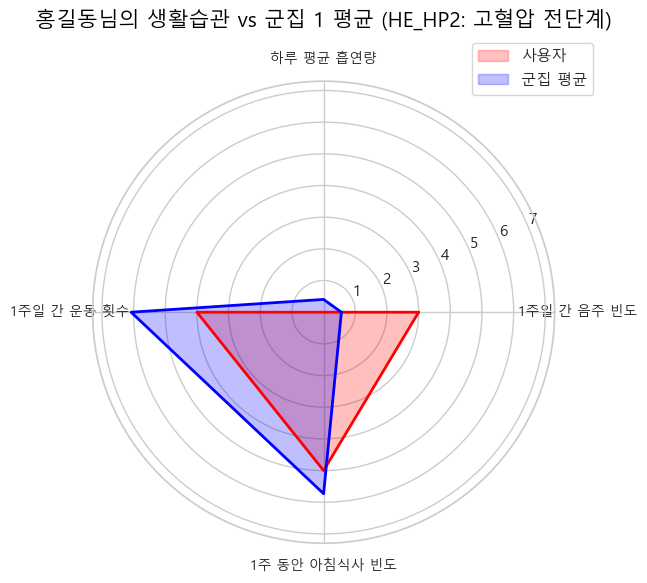

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from math import pi

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: 맑은 고딕으로 설정 (Windows 환경 시)
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드 및 전처리 (제공된 노트북 기반)
# 실제 데이터 파일 경로로 수정 필요
df = pd.read_csv("선택컬럼_건강데이터(2022~2023년)_변수추가.csv")
# --- 데이터 불러오기 대신 더미 데이터프레임을 사용합니다. 실제 사용 시 위 라인의 주석을 해제하고 아래 더미 데이터프레임은 제거해주세요. ---


# 전처리
df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({ #	1주일간 걷기 일수
'1.0' : 0,
'2.0' : 1,
'3.0' : 2,
'4.0' : 3,
'5.0' : 4,
'6.0' : 5,
'7.0' : 6,
'8.0' : 7,
'88.0' : 0,
'99.0' : np.nan,
'nan' : np.nan
 })
df['BE3_31'] = pd.to_numeric(df['BE3_31'], errors='coerce')

# 전처리
df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({ #최근 1년 동안 1주 동안 아침식사 빈도 
'1.0' : 6,
'2.0' : 3.5,
'3.0' : 1.5,
'4.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
 })
df['L_BR_FQ'] = pd.to_numeric(df['L_BR_FQ'], errors='coerce')

# 전처리: tobacco (일반 담배 + 전자 담배 하루 평균 흡연량)
df['BS3_2'] = df['BS3_2'].replace(888, 0)
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan})
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)
df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({'999.0': np.nan})
df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')

# 전처리: BD1_11 (1년간 음주빈도) - 연간 횟수로 변환
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 6, '3.0': 12, '4.0': 42, '5.0': 130, '6.0': 286,
    '8.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

# 고혈압 파생변수 생성 (HE_HP2)
def classify_bp(row):
    sbp = row['HE_sbp1']
    dbp = row['HE_dbp1']
    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan
    if sbp >= 140 or dbp >= 90:
        return 4
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        return 3
    elif 120 <= sbp <= 129 and dbp < 80:
        return 2
    else:
        return 1

df['HE_HP2'] = df.apply(classify_bp, axis=1)
df['HE_HP2'] = pd.to_numeric(df['HE_HP2'], errors='coerce')

# 결측치 제거 및 군집 분석에 사용할 컬럼 선택
df_clustering = df.dropna(subset=['HE_HP2'])
selected_cols = ['BD1_11', 'tobacco', 'BE3_31', 'L_BR_FQ']

# 선택된 컬럼의 결측치를 최빈값으로 대체 (사용자 코드의 로직 유지)
for col in selected_cols:
    if df_clustering[col].isnull().any():
        mode_value = df_clustering[col].mode(dropna=True)
        if not mode_value.empty:
            df_clustering[col].fillna(mode_value[0], inplace=True)
        else:
             df_clustering[col].fillna(0, inplace=True)

# --- 제공된 사전 계산된 군집 평균 데이터 ---
# 이 데이터를 사용하여 군집 예측 및 비교에 활용합니다.
# 컬럼 이름은 제공된 텍스트의 이름을 따릅니다.
import pandas as pd

# The new precalculated_means dictionary based on your provided output

precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.278527, 0.278789, 0.104083, 0.482462, 3.528986, 3.060144],
        '하루 평균 흡연량': [0.309963, 0.665868, 0.188784, 20.408000, 15.536232, 0.556553],
        '1주일 간 걷기 일수': [6.046740, 3.073054, 0.521327, 2.900000, 3.033816, 3.827648],
        '1주 동안 아침식사 빈도': [5.554121, 0.749102, 5.698855, 3.328000, 3.181159, 3.388689]
    }, index=[0, 1, 2, 3, 4, 5]), # Note: k=6 for HE_HP2=1, so indices are 0-5
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [0.296094, 0.361063, 4.435345, 0.637532],
        '하루 평균 흡연량': [1.064062, 0.871355, 9.758621, 2.839888],
        '1주일 간 걷기 일수': [0.962500, 6.130360, 3.448276, 3.196629],
        '1주 동안 아침식사 빈도': [5.722656, 5.695540, 4.465517, 0.646067]
    }, index=[0, 1, 2, 3]), # Note: k=4 for HE_HP2=2, so indices are 0-3
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.403821, 0.561644, 0.805960, 5.500000, 0.839458, 1.536081],
        '하루 평균 흡연량': [0.341656, 0.403583, 2.039039, 5.842697, 1.307692, 19.814286],
        '1주일 간 걷기 일수': [1.057819, 6.077977, 1.138138, 3.679775, 5.894737, 2.776190],
        '1주 동안 아침식사 빈도': [5.812746, 5.731296, 0.762763, 3.977528, 0.546559, 3.888095]
    }, index=[0, 1, 2, 3, 4, 5]), # Note: k=6 for HE_HP2=3, so indices are 0-5
    4: pd.DataFrame({
        '1주일 간 음주 빈도': [2.778281, 0.429768, 0.469723, 5.500000, 0.925240],
        '하루 평균 흡연량': [20.449198, 0.252648, 0.392857, 2.215827, 1.403125],
        '1주일 간 걷기 일수': [2.978610, 0.912254, 6.144345, 3.100719, 3.284375],
        '1주 동안 아침식사 빈도': [3.919786, 5.780635, 5.840030, 4.399281, 0.764062]
    }, index=[0, 1, 2, 3, 4]) # Note: k=5 for HE_HP2=4, so indices are 0-4
}
# --- 사전 계산된 군집 평균 데이터 끝 ---


# 사용자 입력 함수
def get_user_input():
    print("사용자의 생활습관 수치를 입력해주세요.")
    name = input("사용자 이름: ")
    sbp = float(input("수축기 혈압 (mmHg): "))
    dbp = float(input("이완기 혈압 (mmHg): "))
    weekly_alcohol = float(input("1주일 간 음주 빈도 (회): "))
    daily_smoking = float(input("하루 평균 흡연량 (개비): "))
    weekly_exercise = float(input("1주일 간 걷기 일수 (회): "))
    daily_veg = float(input("1주 동안 아침식사 빈도 (회): "))
    return name, sbp, dbp, weekly_alcohol, daily_smoking, weekly_exercise, daily_veg

# HE_HP2 결정 함수 (위에 이미 정의됨)
# HE_HP2 결정 함수
def determine_he_hp2(sbp, dbp):
    if sbp >= 140 or dbp >= 90:
        return 4
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        return 3
    elif 120 <= sbp <= 129 and dbp < 80:
        return 2
    else:
        return 1


# 군집 결정 함수 (사전 계산된 평균을 이용하도록 수정)
# 이 함수는 군집 분석을 새로 수행하는 대신, 사용자 데이터를 스케일링하고
# 사전 계산된 평균 중심점과의 거리를 계산하여 가장 가까운 군집을 반환합니다.
def determine_cluster_with_precalculated_means(user_data_weekly_daily, hp_value, scaler, precalculated_means_dict, selected_cols):
    hp_value_int = int(hp_value) # 정수형으로 사용

    if hp_value_int not in precalculated_means_dict:
        print(f"사전 계산된 군집 평균 데이터에 HE_HP2={hp_value_int} 그룹이 없습니다.")
        return None, None

    # 해당 HE_HP2 그룹의 사전 계산된 평균 데이터 가져오기
    cluster_means_precalculated_text_names = precalculated_means_dict[hp_value_int].copy()

    # Define mapping from text names to internal selected_cols names
    text_to_internal_col_mapping = {
        '1주일 간 음주 빈도': 'BD1_11',
        '하루 평균 흡연량': 'tobacco',
        '1주일 간 걷기 일수': 'BE3_31',
        '1주 동안 아침식사 빈도': 'L_BR_FQ'
    }

    # Create a DataFrame with internal names and in selected_cols order
    # Note: Ensure the order of columns in this DataFrame matches the order in selected_cols
    # as the scaler was fit on data in selected_cols order.
    cluster_means_precalculated_internal_names = pd.DataFrame(index=cluster_means_precalculated_text_names.index)
    for internal_col in selected_cols:
        # Find the text column name corresponding to the internal column name
        text_col = next((k for k, v in text_to_internal_col_mapping.items() if v == internal_col), None)

        if text_col and text_col in cluster_means_precalculated_text_names.columns:
            cluster_means_precalculated_internal_names[internal_col] = cluster_means_precalculated_text_names[text_col]
        else:
            # Handle case where a column is missing or mapping is incorrect
            print(f"경고: 내부 컬럼 '{internal_col}'에 대한 텍스트 이름 매핑이 없거나 사전 계산된 데이터에 없습니다.")
            cluster_means_precalculated_internal_names[internal_col] = np.nan # 또는 적절한 기본값


    # 스케일링된 사전 계산된 중심점 (군집 평균)
    # 스케일링에 사용될 scaler는 해당 HE_HP2 그룹의 데이터로 fit 되어 있어야 합니다. (메인 함수에서 fit 후 전달)
    # Note: Ensure cluster_means_precalculated_internal_names has no NaNs before scaling
    if cluster_means_precalculated_internal_names.isnull().values.any():
         print("경고: 스케일링하려는 사전 계산된 평균 데이터에 결측치가 포함되어 있습니다.")


    scaled_precalculated_centroids = scaler.transform(cluster_means_precalculated_internal_names[selected_cols]) # selected_cols 순서 사용


    # 사용자 데이터를 군집 분석의 특성 형식(연간음주, 하루흡연, 주간근력운동, 연간채소)으로 변환
    user_data_transformed_for_predict = [
        user_data_weekly_daily[0] * 52, # 1주일 음주 * 52 -> 연간 음주 (BD1_11 unit)
        user_data_weekly_daily[1], # 하루 흡연 (tobacco unit)
        user_data_weekly_daily[2], # 1주일 걷기 일수 
        user_data_weekly_daily[3]  # 아침식사
    ]

    # 스케일링된 사용자 데이터
    user_data_scaled_for_predict = scaler.transform([user_data_transformed_for_predict])

    # 사용자와 각 중심점 간의 거리 계산
    # numpy 배열 간의 브로드캐스팅을 이용하여 거리 계산
    distances = np.linalg.norm(scaled_precalculated_centroids - user_data_scaled_for_predict, axis=1)

    # 가장 가까운 중심점 (군집) 찾기
    closest_cluster = np.argmin(distances)

    # 해당 군집의 평균 데이터 (원본 스케일, 텍스트 컬럼명 그대로)
    # precalculated_means_dict[hp_value_int]는 이미 텍스트 컬럼명과 사용자 단위의 DataFrame임
    cluster_means = precalculated_means_dict[hp_value_int].iloc[closest_cluster]

    # 군집 번호와 해당 군집의 평균 데이터 반환
    return closest_cluster, cluster_means


# 레이더 차트 생성 함수 (오류 수정)
def plot_radar_chart(user_data_weekly_daily, cluster_mean_weekly_daily, categories, title):
    # user_data_weekly_daily와 cluster_mean_weekly_daily는 이미 주간/일간 단위의 리스트 또는 Series
    values_user = user_data_weekly_daily[:] # List
    # cluster_mean_weekly_daily는 Series 또는 List가 올 수 있음.
    # Series의 경우 .tolist()로 변환하거나 list()로 감싸서 리스트로 만듦.
    # 현재 코드에서는 이미 리스트로 전달되고 있음.
    values_cluster = cluster_mean_weekly_daily[:] # List

    # 최대값 설정 (차트 범위 조절)
    # all_values = values_user + values_cluster.tolist() # <-- 오류 발생 부분: values_cluster는 이미 list
    all_values = values_user + values_cluster # List와 List를 합침

    max_val = max(all_values) if all_values else 1 # 데이터 없을 경우 대비

    # Extend for radar chart closure
    values_user = values_user + values_user[:1]  # Already a list
    # values_cluster = values_cluster.tolist() + values_cluster[:1].tolist() # <-- 오류 발생 부분
    values_cluster = values_cluster + values_cluster[:1] # List와 List 슬라이스를 합침

    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Set the maximum value for the radar chart axes
    ax.set_ylim(0, max_val * 1.2)

    ax.fill(angles, values_user, color='red', alpha=0.25, label='사용자')
    ax.plot(angles, values_user, color='red', linewidth=2)
    ax.fill(angles, values_cluster, color='blue', alpha=0.25, label='군집 평균')
    ax.plot(angles, values_cluster, color='blue', linewidth=2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_title(title, size=15, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    ax.grid(True)
    plt.show()


# 메인 서비스 함수
def health_comparison_service():
    name, sbp, dbp, weekly_alcohol, daily_smoking, weekly_exercise, daily_veg = get_user_input()
    he_hp2 = determine_he_hp2(sbp, dbp)
    he_hp2_labels = {1: "정상", 2: "주의", 3: "고혈압 전단계", 4: "고혈압"}

    if pd.isna(he_hp2):
        print(f"\n혈압 수치 ({sbp}/{dbp})가 유효하지 않아 HE_HP2 분류를 할 수 없습니다.")
        return

    he_hp2_int = int(he_hp2) # 정수형으로 사용

    if he_hp2_int not in precalculated_means:
        print(f"\nHE_HP2 그룹 {he_hp2_int}에 대한 사전 계산된 군집 평균 데이터가 없습니다.")
        return

    print(f"\n{name}님은 수축기 혈압 {sbp}, 이완기 혈압 {dbp}를 고려했을 때 HE_HP2 = {he_hp2_int}, {he_hp2_labels[he_hp2_int]}에 속합니다.")

    # 해당 HE_HP2 그룹의 데이터 추출 (스케일링을 위해 필요)
    # df_clustering는 위 전처리 단계에서 HE_HP2 결측치 제거 후 생성된 데이터프레임
    hp_df = df_clustering[df_clustering['HE_HP2'] == he_hp2_int][selected_cols].copy()

    # 해당 그룹에 데이터가 충분한지 확인 (스케일링 fit 시 필요)
    if hp_df.empty:
         print(f"\nHE_HP2 그룹 {he_hp2_int}에 데이터가 없어 비교를 수행할 수 없습니다.")
         return

    # StandardScaler 객체를 해당 그룹의 데이터로 fit (사전 계산된 평균과 사용자 데이터 스케일링에 사용)
    scaler = StandardScaler()
    scaler.fit(hp_df[selected_cols]) # selected_cols 순서와 이름으로 fit

    # determine_cluster 함수에 사용자 입력 주간/일간 단위를 그대로 전달
    user_data_for_cluster_input = [weekly_alcohol, daily_smoking, weekly_exercise, daily_veg]

    # 사전 계산된 평균을 이용하여 가장 가까운 군집 결정
    # determine_cluster_with_precalculated_means 함수 호출
    cluster, cluster_means_for_comparison = determine_cluster_with_precalculated_means(
        user_data_for_cluster_input, he_hp2_int, scaler, precalculated_means, selected_cols
    )

    if cluster is not None:
        # cluster_means_for_comparison는 이미 해당 군집의 사전 계산된 평균 (텍스트 컬럼명, 사용자 단위) Series
        print(f"1주일 간 음주 빈도, 하루 평균 흡연량, 1주일 간 걷기 일수, 1주 동안 아침식사 빈도를 고려했을 때 {he_hp2_labels[he_hp2_int]} 그룹의 {cluster}번 군집에 속합니다.")

        # --- 테이블 비교 출력 ---
        print("\n✅ 사용자 생활습관 vs 군집 평균 비교:")

        # User input values (already in weekly/daily)
        user_values = [weekly_alcohol, daily_smoking, weekly_exercise, daily_veg]

        # Comparison cluster mean values (matching user units)
        # cluster_means_for_comparison는 이미 Series 형태로 사용자 단위 평균을 가지고 있음
        cluster_comp_values = cluster_means_for_comparison.tolist() # Series를 리스트로 변환하여 전달

        # 항목 이름 (사용자 입력 항목명과 일치)
        item_names = ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 운동 횟수', '1주 동안 아침식사 빈도'] # 오타 수정 완료

        # Create data for the table
        table_data = {
            '항목': item_names,
            f'{name}님 수치': user_values,
            f'군집 {cluster} 평균 수치': cluster_comp_values
        }

        # Create and print the DataFrame
        comparison_df = pd.DataFrame(table_data)
        # 소수점 둘째 자리까지 표시하도록 float 형식 지정
        print(comparison_df.to_markdown(index=False, floatfmt=".2f")) # Markdown 형식으로 깔끔하게 출력

        # --- 테이블 비교 출력 끝 ---


        # 레이더 차트용 데이터 준비 (테이블 비교에서 사용한 단위 그대로 사용)
        categories = item_names # 테이블 항목명을 그대로 사용

        # 레이더 차트 그리기
        # plot_radar_chart 함수는 user_data (weekly/daily list)와 cluster_mean (weekly/daily list)를 받음
        plot_radar_chart(user_values, cluster_comp_values, categories, f"{name}님의 생활습관 vs 군집 {cluster} 평균 (HE_HP2: {he_hp2_labels[he_hp2_int]})")


    else:
        # determine_cluster_with_precalculated_means 함수에서 이미 메시지 출력
        pass


# 서비스 실행
if __name__ == "__main__":
    health_comparison_service()